# Downscaled `tasmax` days above 40°C

This notebook is for exploring downscaled data for values above 40°C. It was designed to work for the zarr outputs from the 4km ERA5-based CMIP6 downscaling effort. 


Initial testing of the downscaled `tasmax` data revealed that data for the following models had values above 40°C:
* CNRM-CM6-1-HR
* E3SM-2-0
* EC-Earth3-Veg
* HadGEM3-GC31-LL
* HadGEM3-GC31-MM
* KACE-1-0-G
* NorESM2-MM
* TaiESM1

No such values were found in the downscaled historical data, which makes sense as, the maximum value found in the WRF-downscaled 4km t2_max data is approximately 34°C. 

This notebook simply downscaled `tasmax` data with days over 40 °C counted and plotted in red.

In [17]:
import os
import numpy as np
import xarray as xr
from pathlib import Path
from xclim.core.units import convert_units_to
import matplotlib.pyplot as plt
import gc

zarr_dir = Path(
    os.getenv("ZARR_DIR", "/center1/CMIP6/kmredilla/cmip6_4km_downscaling/adjusted")
)

In [ ]:
# function to plot hot tasmax values
def plot_hot_tasmax(model, scenario):
    zarr_store = zarr_dir.joinpath(f"tasmax_{model}_{scenario}_adjusted.zarr")

    ds = xr.open_zarr(zarr_store)
    tasmax = convert_units_to(ds.tasmax, "degC")

    # Compute the mean tasmax over time
    tasmax_mean = tasmax.mean("time")

    tasmax_hot = tasmax > 40
    tasmax_hot_count = tasmax_hot.sum("time")

    # Prepare values for histogram
    tasmax_hot_values = tasmax.where(tasmax_hot).values.flatten()
    tasmax_hot_values = tasmax_hot_values[~np.isnan(tasmax_hot_values)]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Hot tasmax analysis for {model}, {scenario}", fontsize=14)

    # Plot the mean tasmax as a muted background
    axs[0].imshow(
        tasmax_mean.transpose("y", "x").values,
        cmap="Greys",
        alpha=0.5,
        interpolation="none",
    )

    # Overlay the hot day counts using a red color palette, masking zeros for clarity
    masked_hot = np.ma.masked_where(
        tasmax_hot_count.transpose("y", "x") == 0, tasmax_hot_count.transpose("y", "x")
    )
    im = axs[0].imshow(masked_hot, cmap="Reds", alpha=0.8, interpolation="none")

    plt.colorbar(im, ax=axs[0], label="Count of Days > 40°C (Red Overlay)")
    axs[0].set_title("Mean tasmax (grey) with Hot Day Counts (> 40°C) Overlay")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    # Histogram subplot
    if tasmax_hot_values.size > 0:
        axs[1].hist(tasmax_hot_values, bins=30, color="red", alpha=0.7)
        axs[1].set_xlabel("tasmax (°C)")
        axs[1].set_ylabel("Frequency")
        axs[1].set_title("Histogram of tasmax Values Where tasmax > 40°C")
    else:
        axs[1].text(
            0.5,
            0.5,
            "No tasmax values above 40°C found.",
            ha="center",
            va="center",
            fontsize=12,
        )
        axs[1].set_axis_off()

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    del ds
    del tasmax

    gc.collect()

### CNRM-CM6-1-HR

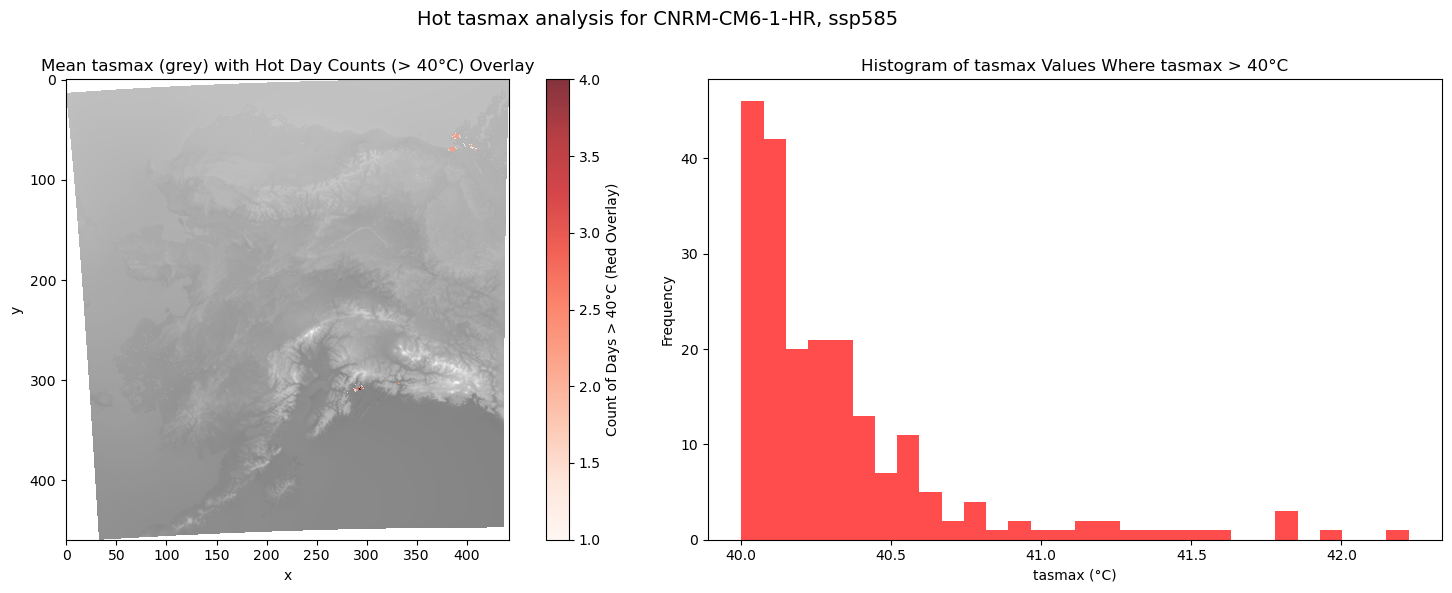

In [19]:
model = "CNRM-CM6-1-HR"
scenario = "ssp585"
plot_hot_tasmax(model, scenario)

### E3SM-2-0

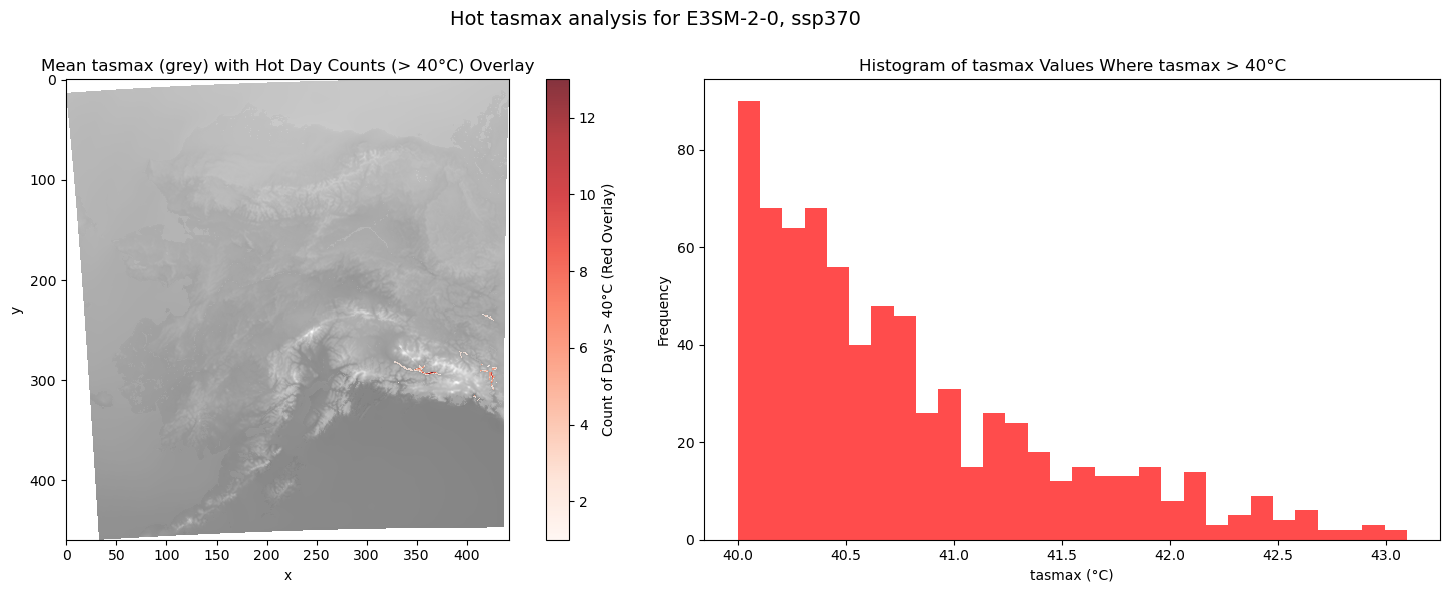

In [20]:
model = "E3SM-2-0"
scenario = "ssp370"
plot_hot_tasmax(model, scenario)

### EC-Earth3-Veg

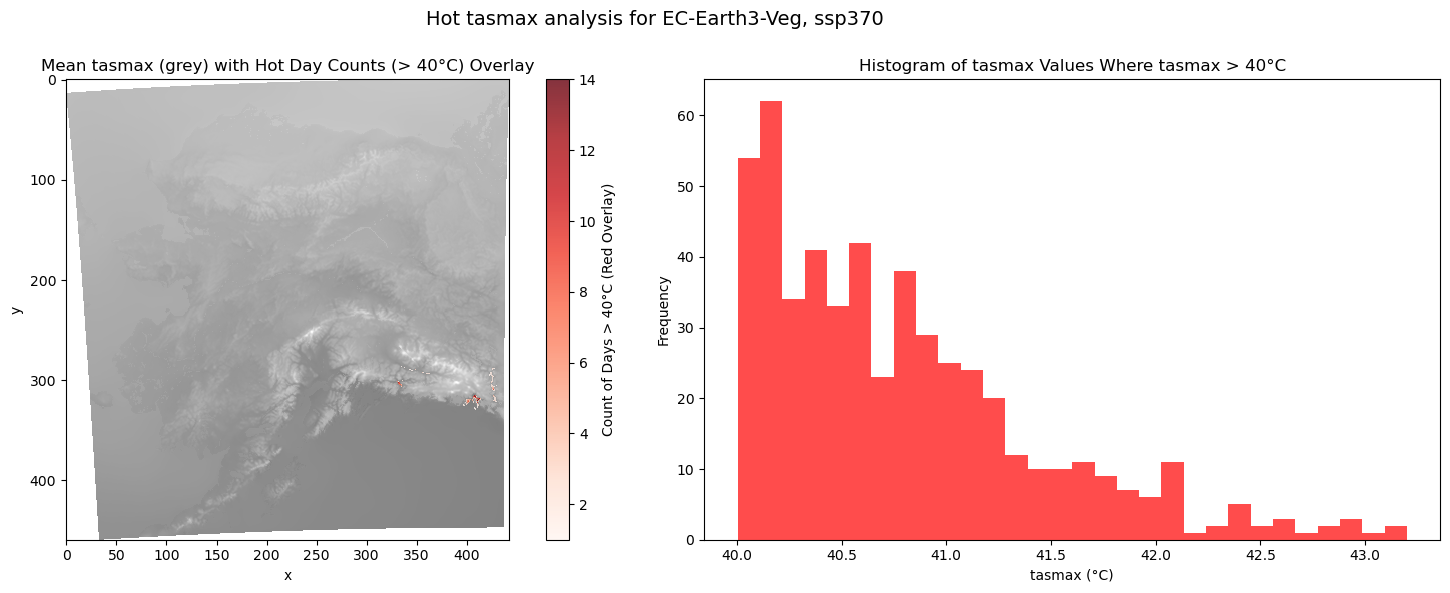

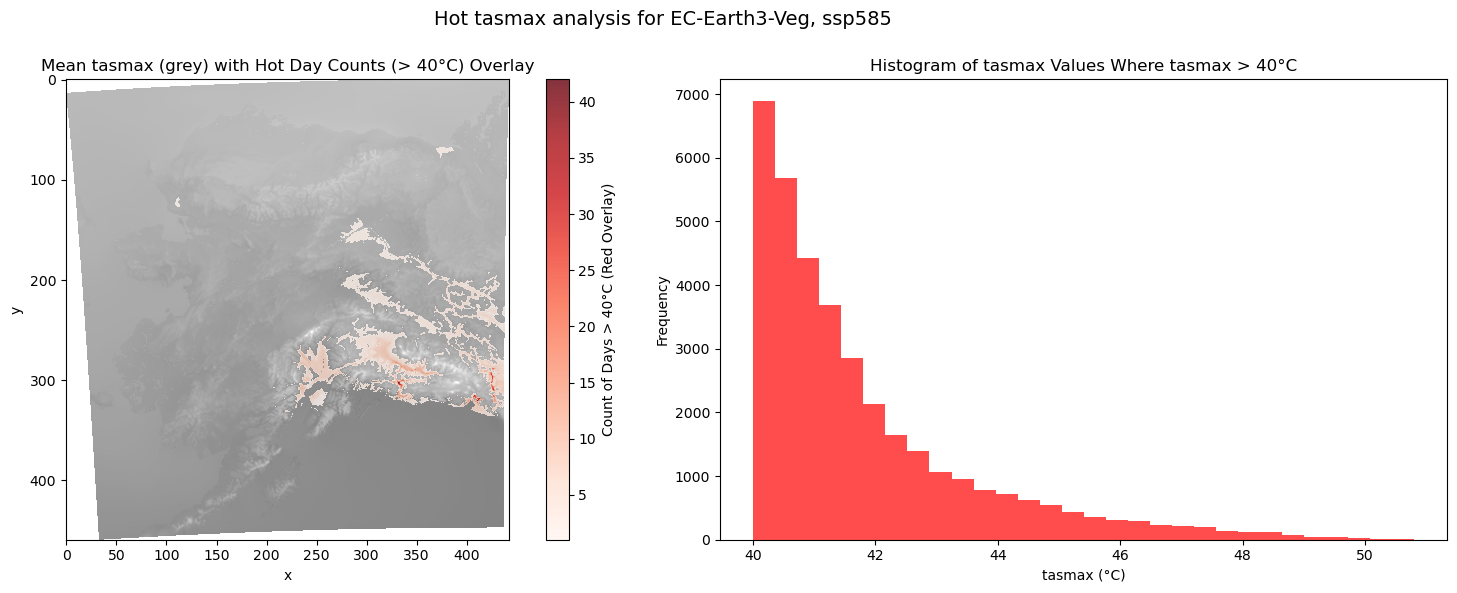

In [21]:
model = "EC-Earth3-Veg"
for scenario in ["ssp370", "ssp585"]:
    plot_hot_tasmax(model, scenario)

### HadGEM3-GC31-LL

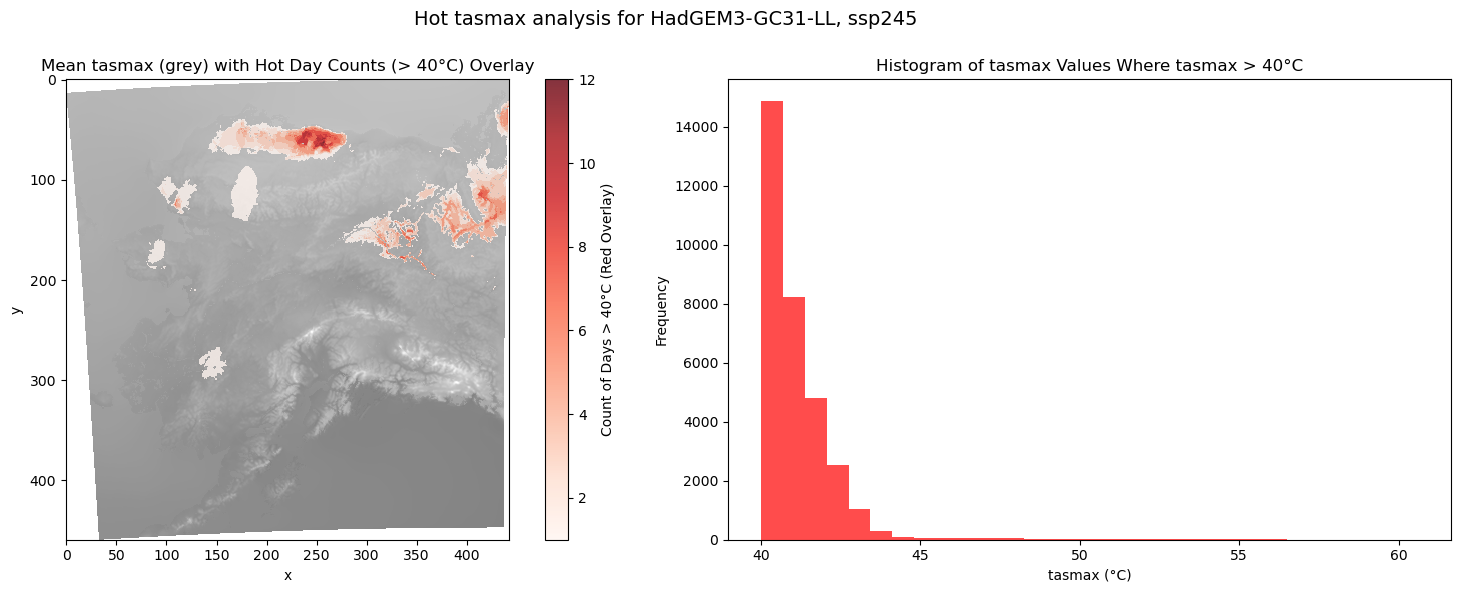

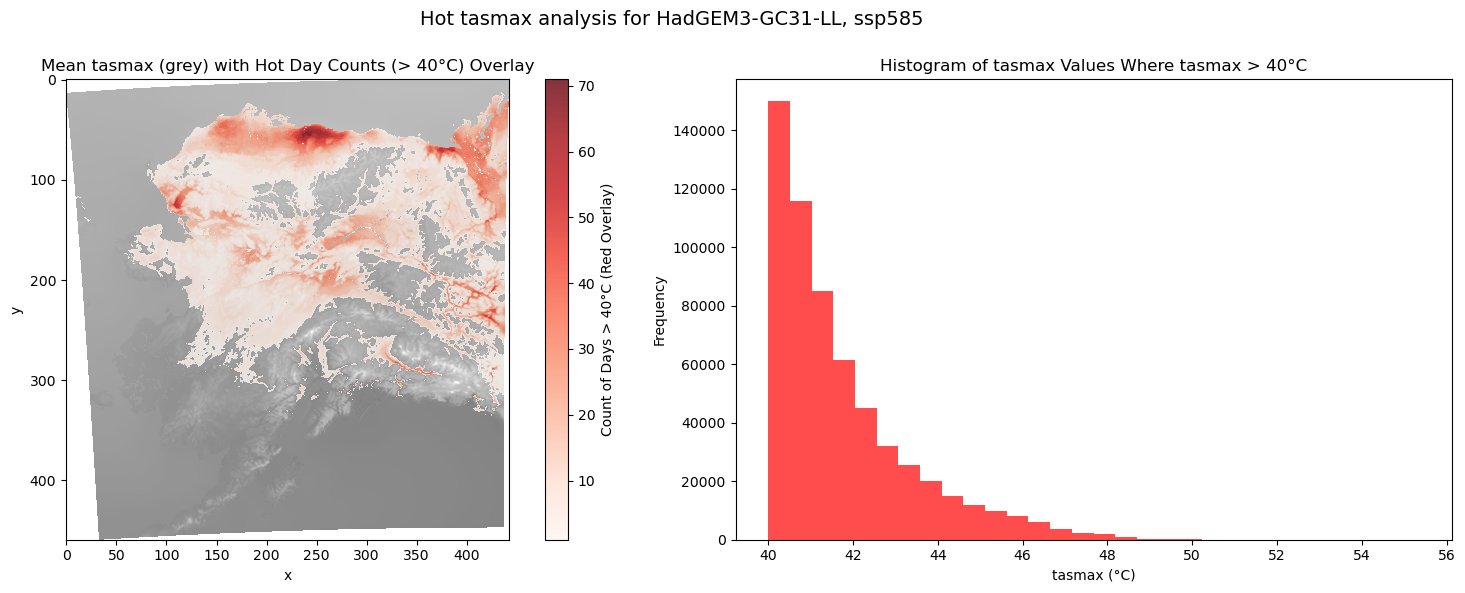

In [22]:
model = "HadGEM3-GC31-LL"
for scenario in ["ssp245", "ssp585"]:
    plot_hot_tasmax(model, scenario)

### HadGEM3-GC31-MM

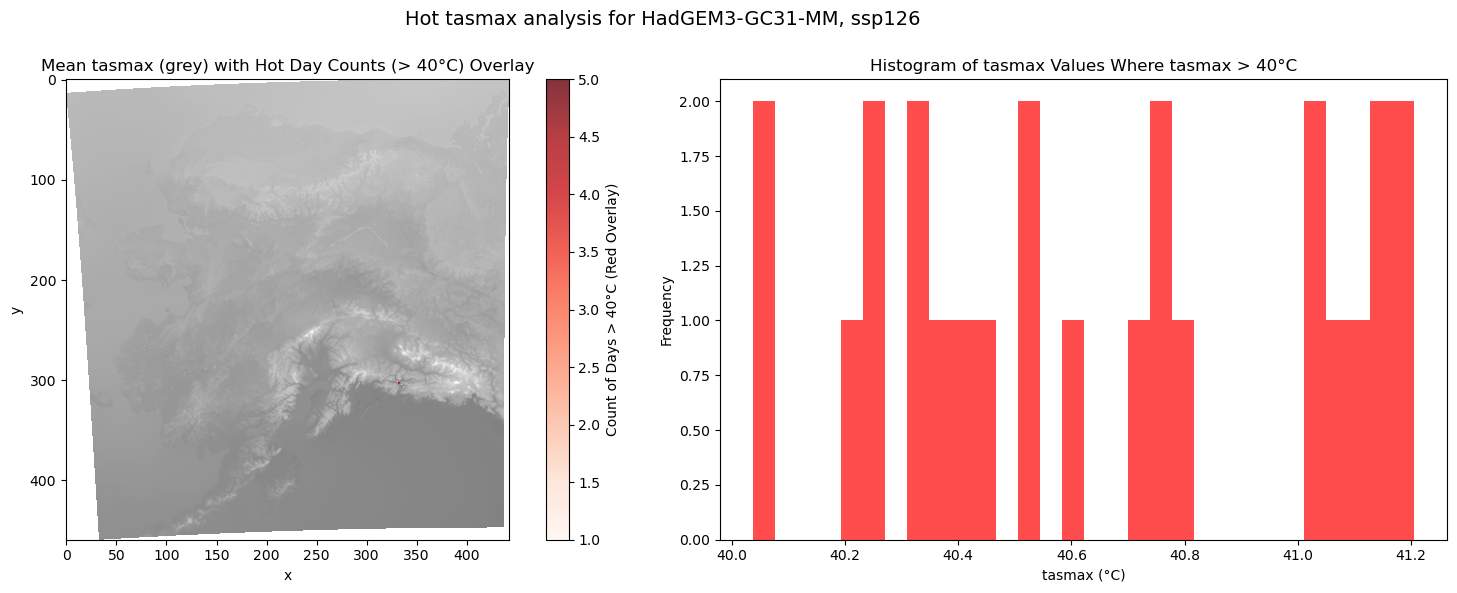

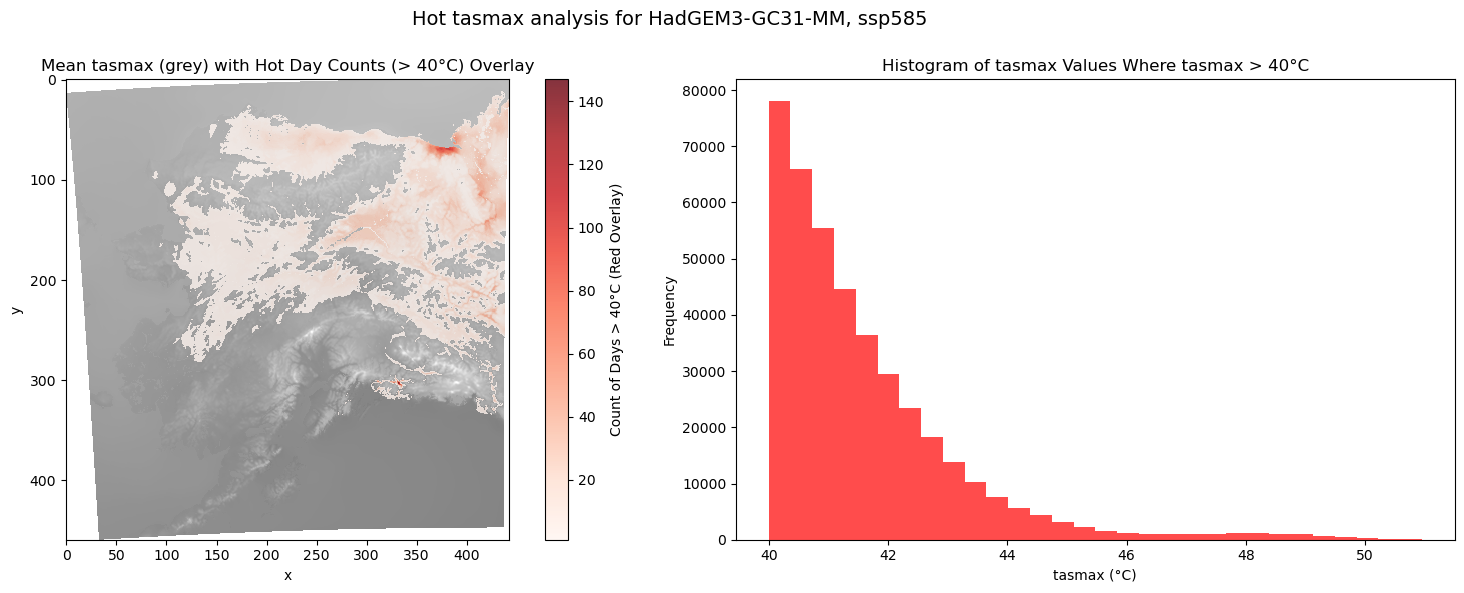

In [23]:
model = "HadGEM3-GC31-MM"
for scenario in ["ssp126", "ssp585"]:
    plot_hot_tasmax(model, scenario)

### KACE-1-0-G

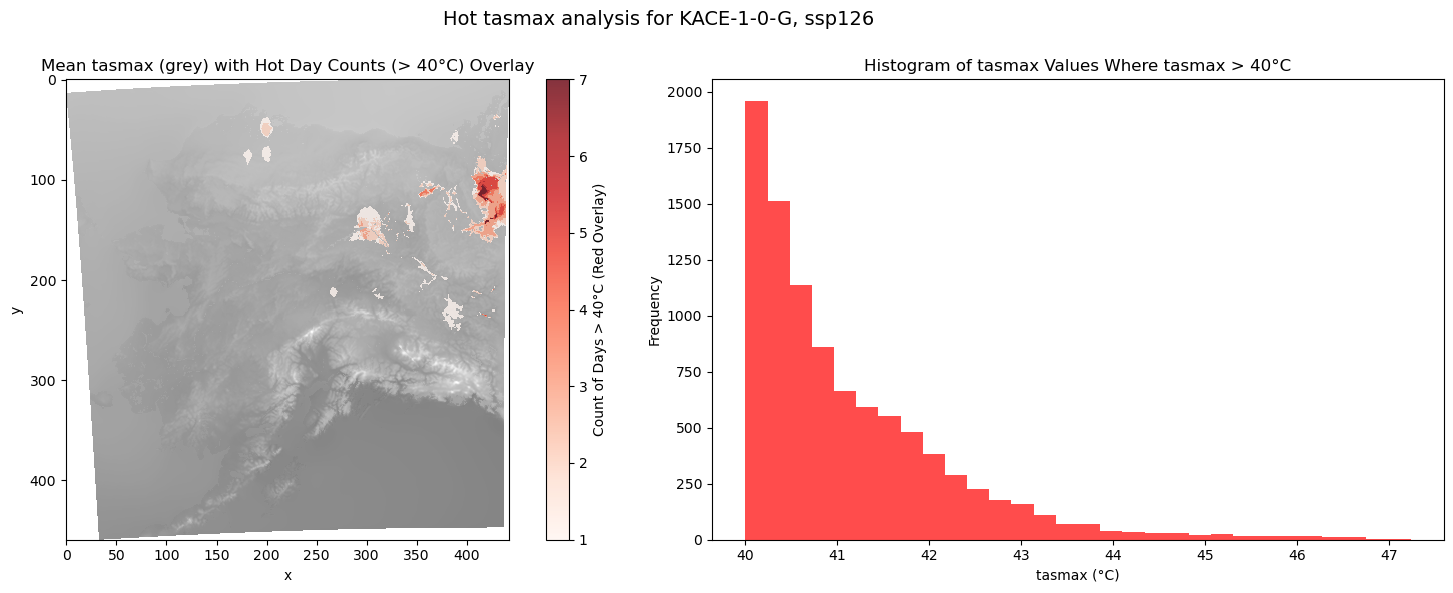

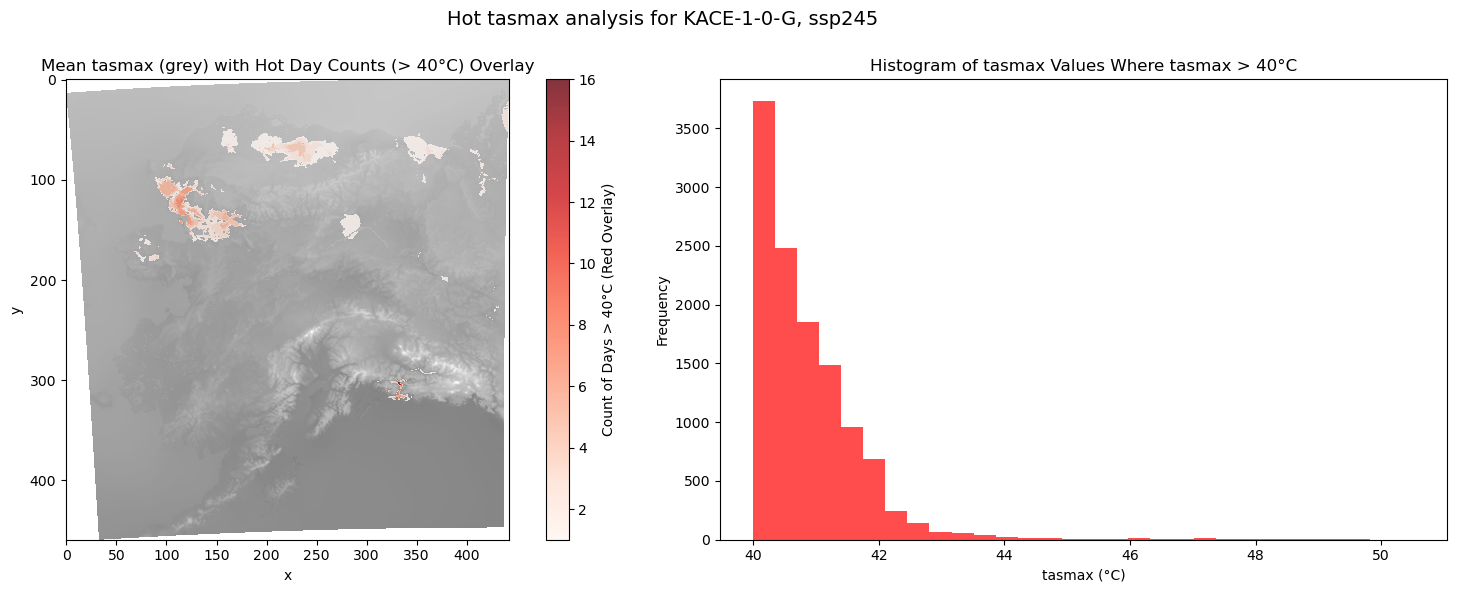

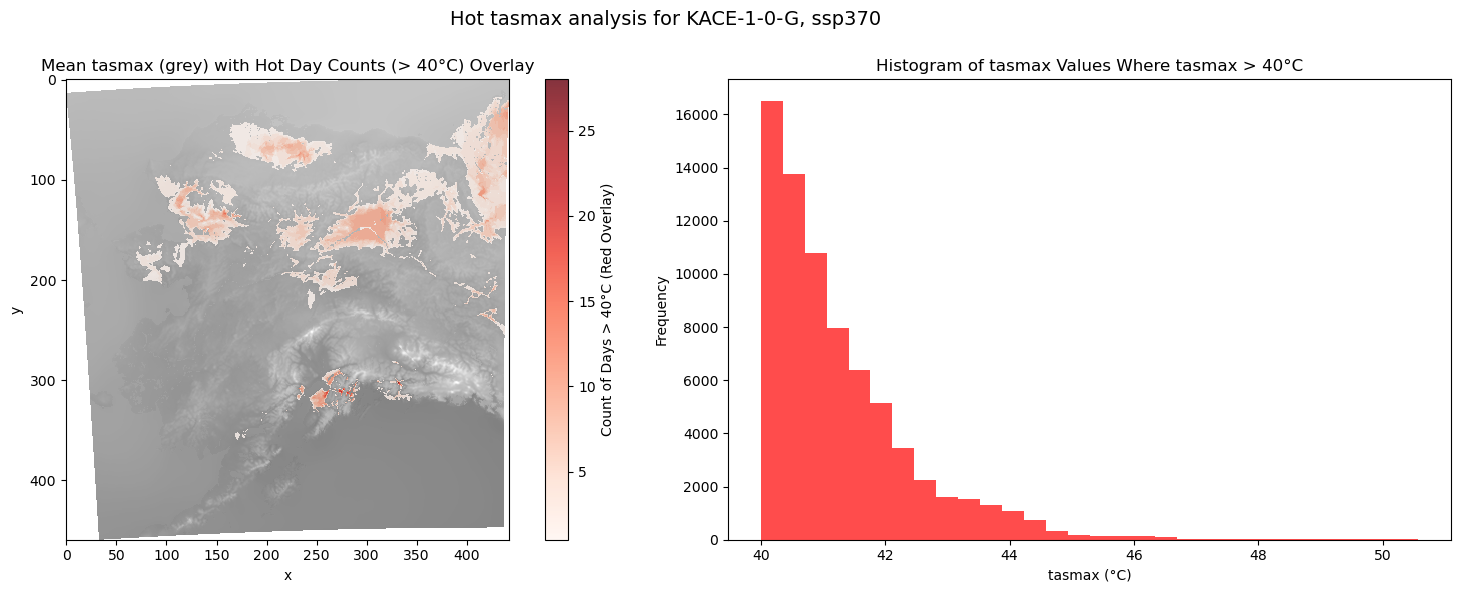

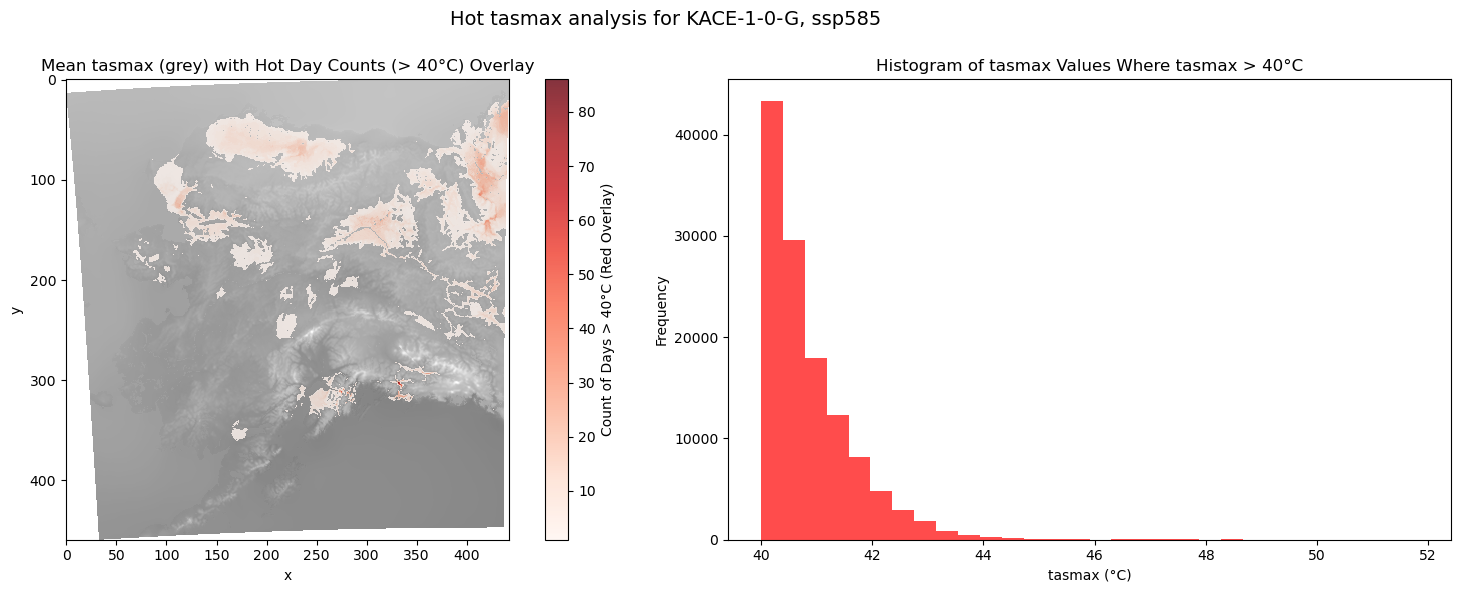

In [24]:
model = "KACE-1-0-G"
for scenario in ["ssp126", "ssp245", "ssp370", "ssp585"]:
    plot_hot_tasmax(model, scenario)

### NorESM2-MM

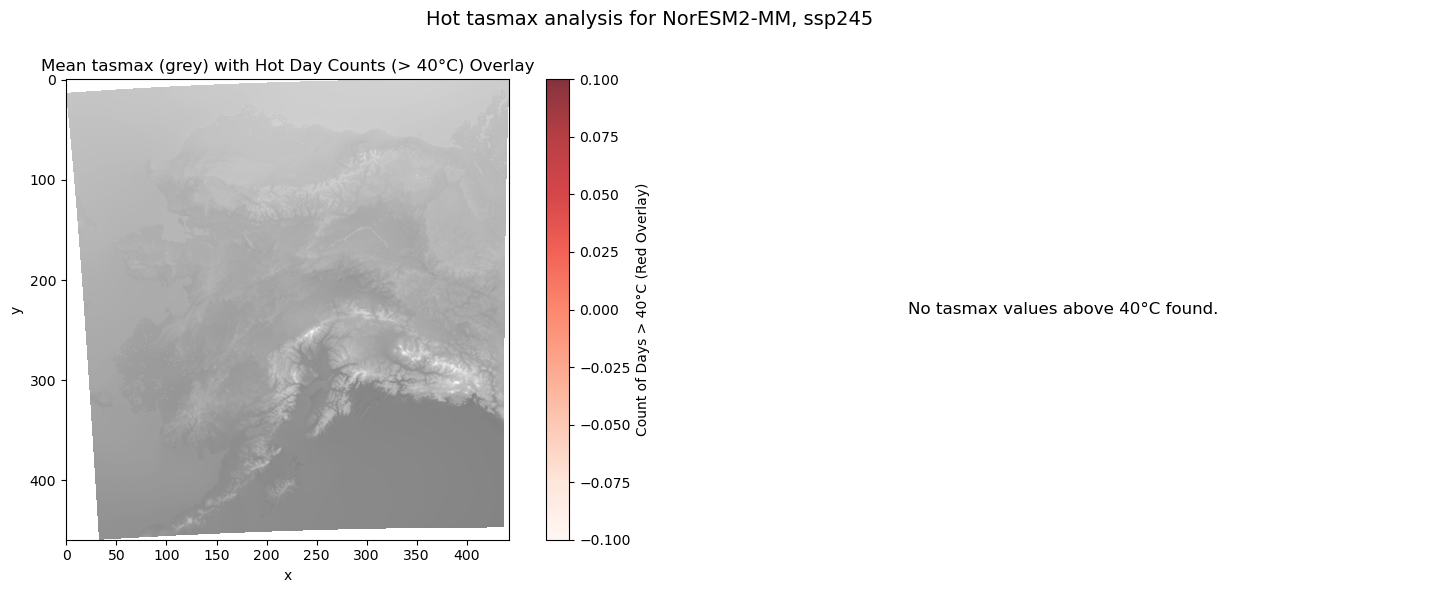

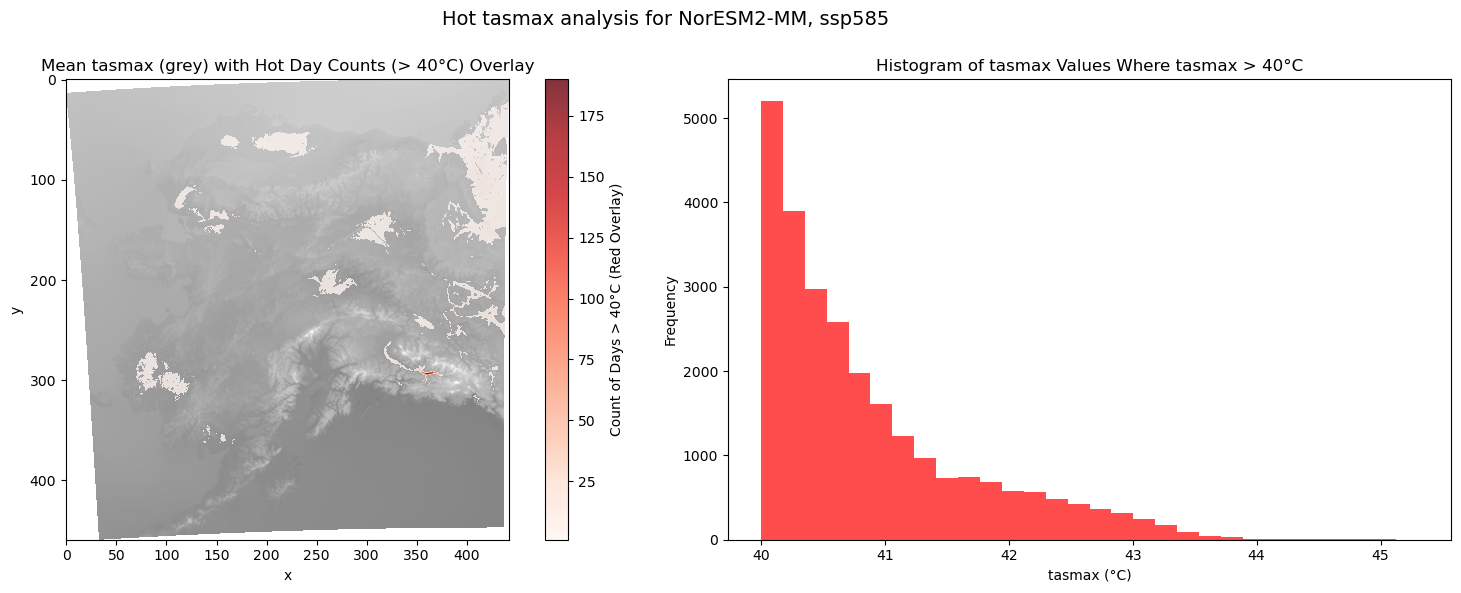

In [25]:
model = "NorESM2-MM"
for scenario in ["ssp245", "ssp585"]:
    plot_hot_tasmax(model, scenario)

### TaiESM1

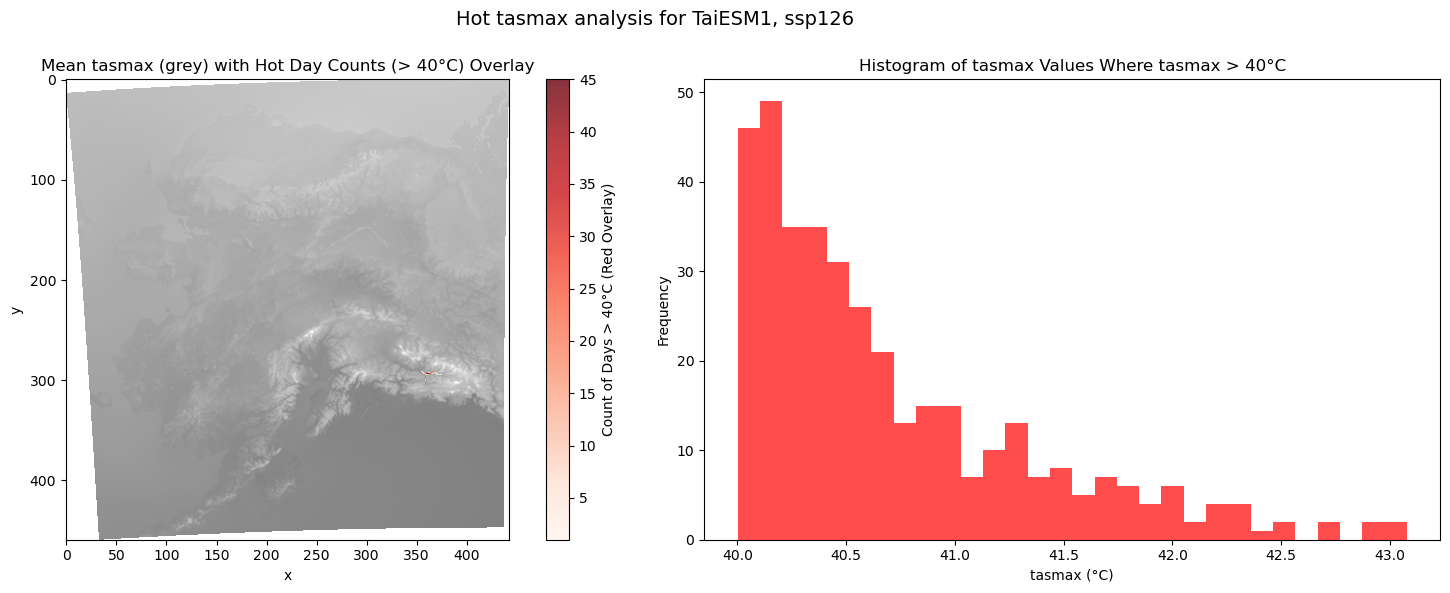

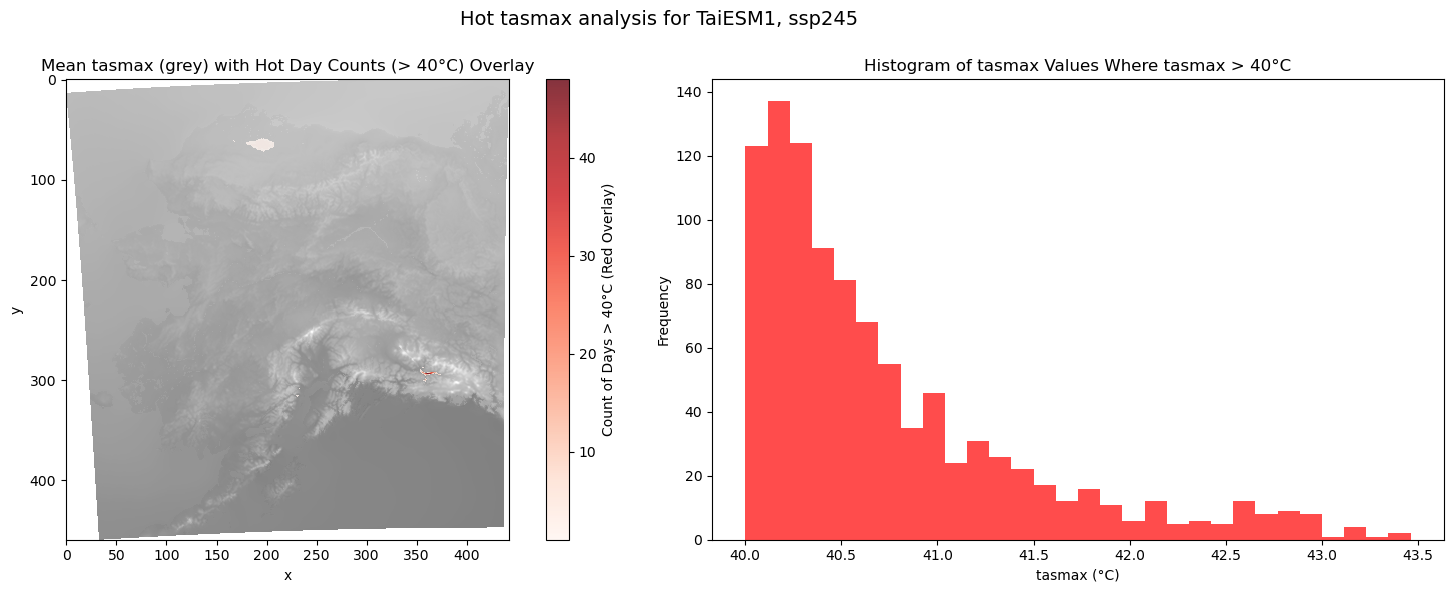

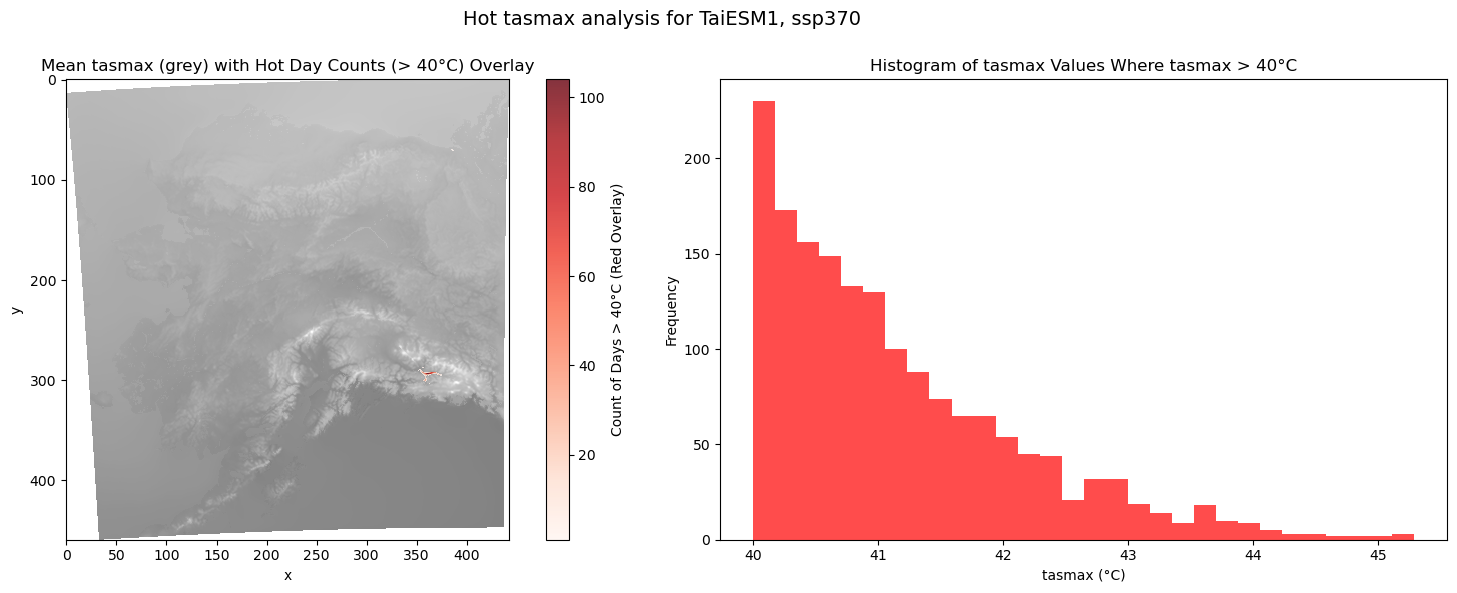

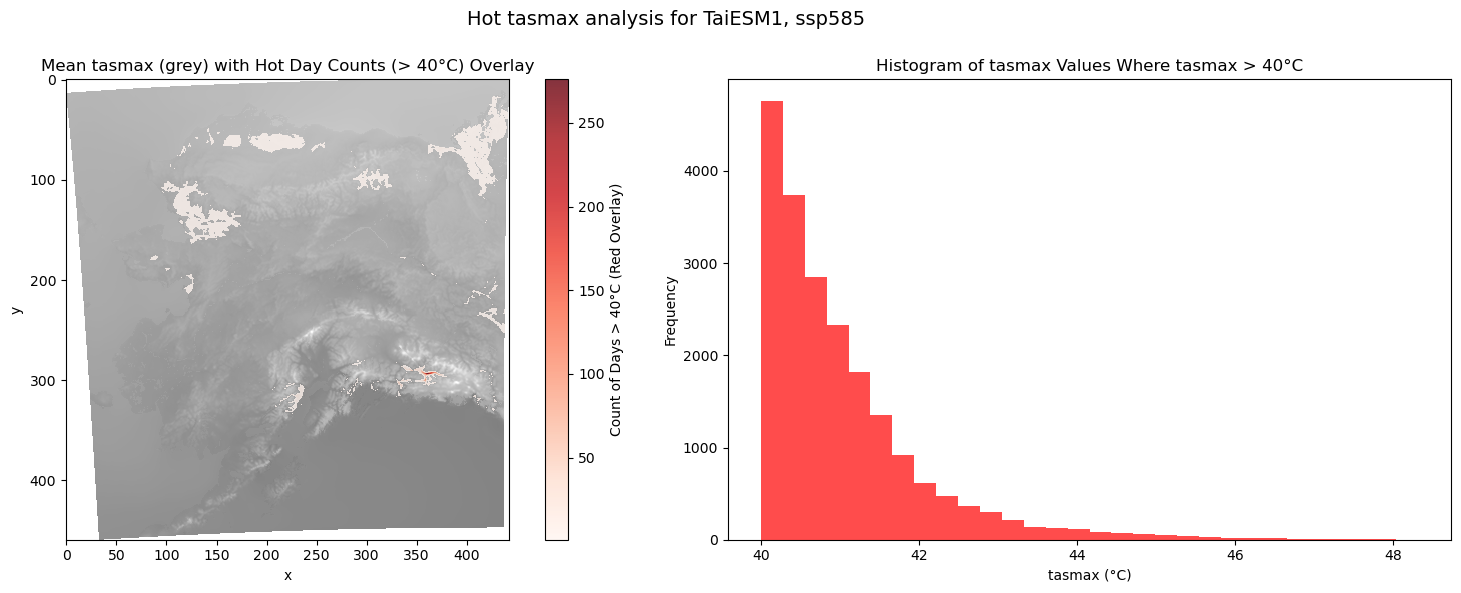

In [26]:
model = "TaiESM1"
for scenario in ["ssp126", "ssp245", "ssp370", "ssp585"]:
    plot_hot_tasmax(model, scenario)

# ECDFs

Here we will explore some of the pixels from each model that have an overabundance of unreasonably high values for `tasmax`. We will do so by plotting empirical cumulative distribution functions to get an idea of why adjustments might be going so whack. 


### EC-Earth3-Veg, SSP585

In [ ]:
zarr_store = zarr_dir.joinpath(f"tasmax_{model}_{scenario}_adjusted.zarr")
ds = xr.open_zarr(zarr_store)
tasmax = convert_units_to(ds.tasmax, "degC")

# Count days above 40°C
hot_days_count = (tasmax > 40).sum(dim="time")

# Flatten and get indices of top 5
flat_hot = hot_days_count.values.flatten()
top5_idx = np.argpartition(flat_hot, -5)[-5:]
top5_sorted = top5_idx[np.argsort(flat_hot[top5_idx])[::-1]]

# Convert flat indices to 2D indices
y_dim, x_dim = hot_days_count.shape
y_coords, x_coords = np.unravel_index(top5_sorted, (y_dim, x_dim))

In [114]:
hot_days_count.notnull()

<xarray.DataArray 'tasmax' (x: 443, y: 460)> Size: 204kB
dask.array<invert, shape=(443, 460), dtype=bool, chunksize=(50, 50), chunktype=numpy.ndarray>
Coordinates:
    lat          (y, x) float64 2MB dask.array<chunksize=(50, 50), meta=np.ndarray>
    lon          (y, x) float64 2MB dask.array<chunksize=(50, 50), meta=np.ndarray>
    spatial_ref  int64 8B ...
  * x            (x) float64 4kB -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 4kB 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05

In [117]:
hot_days_count.load()

<xarray.DataArray 'tasmax' (x: 443, y: 460)> Size: 2MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
    lat          (y, x) float64 2MB 70.99 71.01 71.02 71.03 ... 54.8 54.8 54.79
    lon          (y, x) float64 2MB -176.7 -176.6 -176.5 ... -139.3 -139.2
    spatial_ref  int64 8B 0
  * x            (x) float64 4kB -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 4kB 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05

NameError: name 'top5_da' is not defined

In [ ]:
def open_tasmax(model, scenario):
    zarr_store = zarr_dir.joinpath(f"tasmax_{model}_{scenario}_adjusted.zarr")
    ds = xr.open_zarr(zarr_store)
    tasmax = convert_units_to(ds.tasmax, "degC")
    return tasmax


def get_top6_hot_pixels(tasmax):
    # Count days above 40°C
    hot_days_count = (tasmax > 40).sum(dim="time").load()
    flat_hot = hot_days_count.values.flatten()

    top6_da = hot_days_count.where(hot_days_count >= np.sort(flat_hot)[-6], drop=True)
    top6_yx = np.argwhere(~np.isnan(top6_da.values))
    # limit to top 6
    top6_y = top6_da.y.values[top6_yx[:, 0]][:6]
    top6_x = top6_da.x.values[top6_yx[:, 1]][:6]

    return list(zip(top6_x, top6_y))


def plot_top6_hot_pixels(tasmax, top6_pixels):
    tasmax_mean = tasmax.mean("time")
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    tasmax_mean.transpose("y", "x").plot(ax=ax, cmap="Greys")
    top6_x, top6_y = zip(*top6_pixels)
    ax.scatter(top6_x, top6_y, color="red", s=5, label="Top 6 Hot Pixels")
    plt.title("Mean tasmax with Top 6 Hot Pixels (>40°C) Highlighted")
    plt.legend()
    plt.show()

Top 6 (x, y) coordinates with highest counts of days > 40°C:
1. (x: 499215.69, y: 1265600.84), count above 40°C: 86
2. (x: 503224.52, y: 1265600.84), count above 40°C: 54
3. (x: 499215.69, y: 1261592.01), count above 40°C: 62
4. (x: 503224.52, y: 1261592.01), count above 40°C: 69
5. (x: 507233.34, y: 1261592.01), count above 40°C: 6
6. (x: 507233.34, y: 1257583.19), count above 40°C: 58


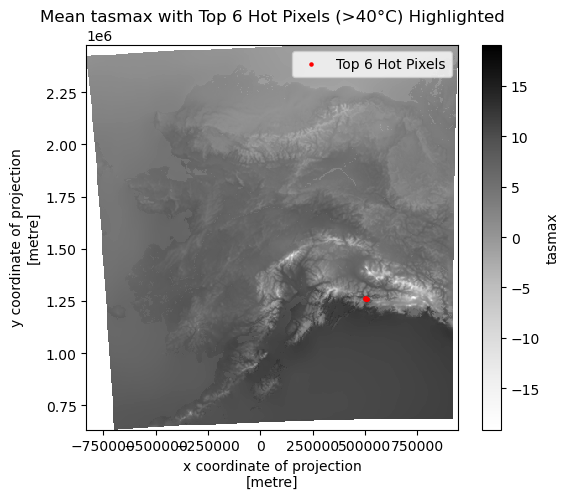

In [ ]:
# open the downscaled dataset
model = "KACE-1-0-G"
scenario = "ssp585"

tasmax = open_tasmax(model, scenario)
top6_pixels = get_top6_hot_pixels(tasmax)

print("Top 6 (x, y) coordinates with highest counts of days > 40°C:")
for idx, (x, y) in enumerate(top6_pixels, start=1):
    print(
        f"{idx}. (x: {x:.2f}, y: {y:.2f}), count above 40°C: {(tasmax.sel(x=x, y=y).values > 40).sum()}"
    )

plot_top6_hot_pixels(tasmax, top6_pixels)

In [148]:
# open ERA5 t2max
ref_dir = Path("/center1/CMIP6/kmredilla/cmip6_4km_downscaling/era5_zarr")
era5_ds = xr.open_dataset(ref_dir.joinpath("t2max_era5.zarr"))

# open historical and projected CMIP6 tasmax, regridded but not bias-corrected
sim_dir = Path("/center1/CMIP6/kmredilla/cmip6_4km_downscaling/cmip6_zarr")
sim_ds = xr.open_dataset(sim_dir.joinpath(f"tasmax_{model}_{scenario}.zarr"))
hist_ds = xr.open_dataset(sim_dir.joinpath(f"tasmax_{model}_historical.zarr"))

In [ ]:
# extract the data for the hot pixel
# get a doys
x = top6_pixels[0][0]
y = top6_pixels[0][1]
era5_extr = era5_ds.t2max.sel(x=x, y=y).rename("tasmax")
hist_extr = hist_ds.tasmax.sel(x=x, y=y)
sim_extr = sim_ds.tasmax.sel(x=x, y=y)

max_doy = hist_extr.where(
    hist_extr == hist_extr.max(), drop=True
).time.dt.dayofyear.item()
doys = list(range(max_doy - 15, max_doy)) + list(range(max_doy, max_doy + 15))

In [ ]:
import pandas as pd
import math


def plot_top6_hot_ecdfs(era5_ds, hist_ds, sim_ds, top6_pixels, thresh):
    n = len(top6_pixels)
    ncols = math.ceil(n / 2)
    nrows = 2

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4), sharey=True)
    axs = axs.flatten()

    for i, (x, y) in enumerate(top6_pixels):
        era5_extr = era5_ds.t2max.sel(x=x, y=y).rename("tasmax")
        hist_extr = hist_ds.tasmax.sel(x=x, y=y)
        sim_extr = sim_ds.tasmax.sel(x=x, y=y)

        max_doy = hist_extr.where(
            hist_extr == hist_extr.max(), drop=True
        ).time.dt.dayofyear.item()
        doys = list(range(max_doy - 15, max_doy)) + list(range(max_doy, max_doy + 15))

        window_df = pd.concat(
            [
                hist_extr.sel(time=hist_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source=f"{model}_historical")
                .to_dataframe()
                .reset_index(),
                era5_extr.sel(time=era5_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source="ERA5")
                .to_dataframe()
                .reset_index(),
                sim_extr.sel(time=sim_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source=f"{model}_{scenario}")
                .to_dataframe()
                .reset_index(),
            ]
        )[["time", "source", "tasmax"]]
        window_df["tasmax"] = window_df["tasmax"] - 273

        sns.ecdfplot(
            window_df.query(f"tasmax > {thresh}"), x="tasmax", hue="source", ax=axs[i]
        )
        axs[i].set_title(f"Pixel {i+1}\n(x={x:.0f}, y={y:.0f})")
        axs[i].set_xlabel("tasmax (°C)")
        if i % ncols == 0:
            axs[i].set_ylabel("ECDF")
        else:
            axs[i].set_ylabel("")

    # Hide any unused subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axs[j])

    plt.suptitle(
        f"ECDF of tasmax for Top 5 Hot Pixels (most occurrences of >40°C) for {model}",
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

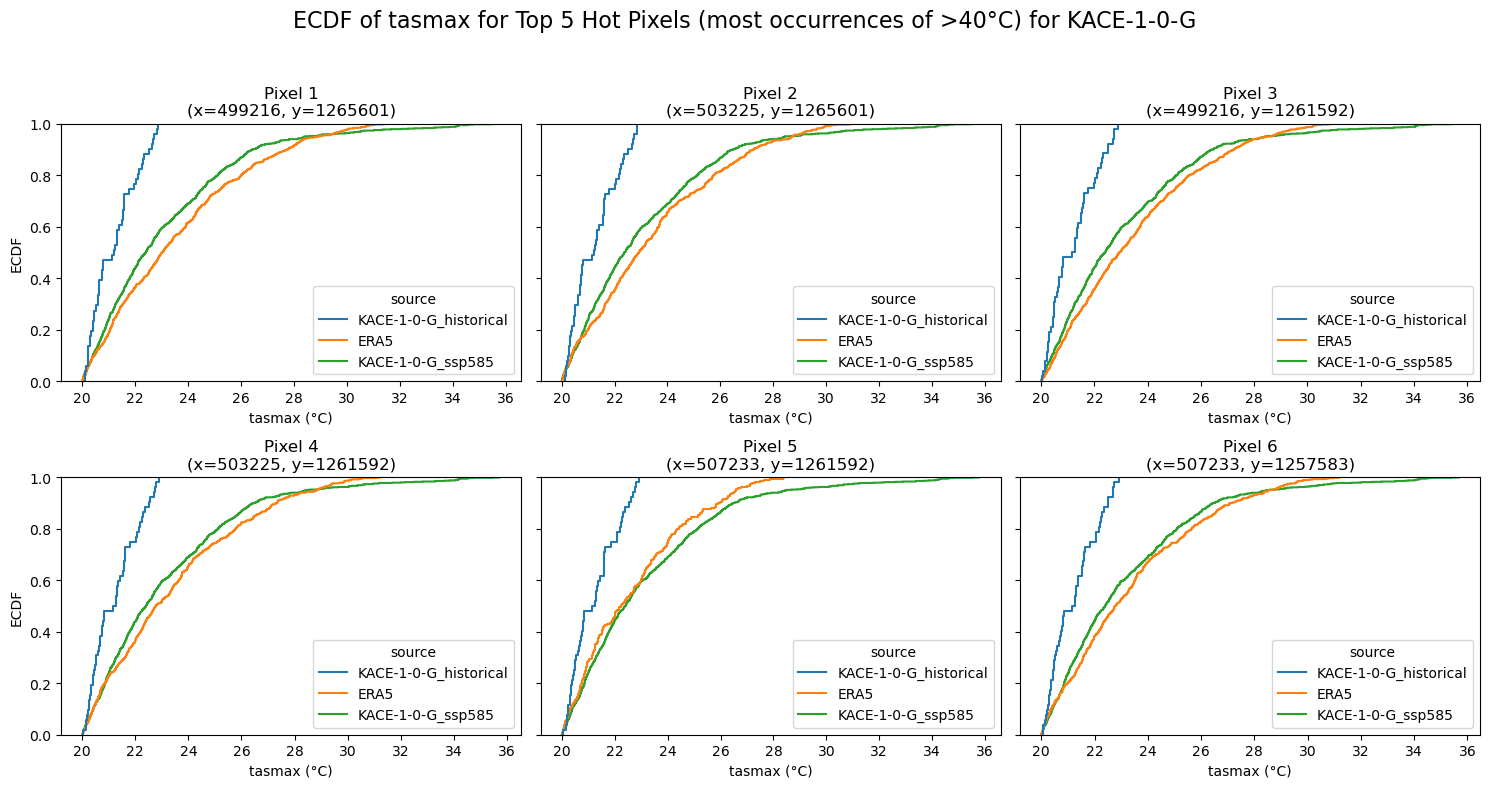

In [208]:
plot_top6_hot_ecdfs(era5_ds, hist_ds, sim_ds, top6_pixels, thresh=20)

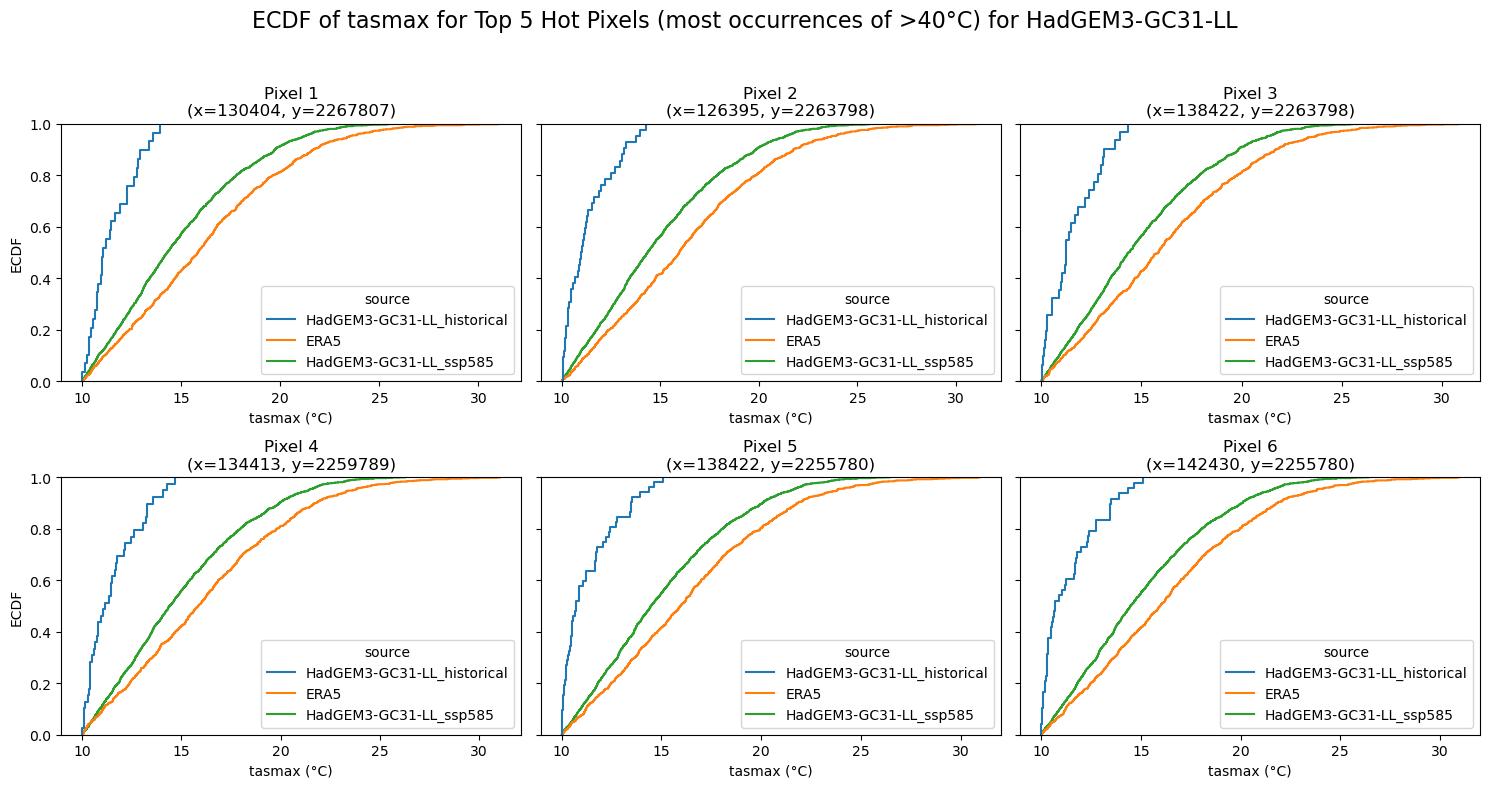

In [209]:
model = "HadGEM3-GC31-LL"
scenario = "ssp585"

tasmax = open_tasmax(model, scenario)
top6_pixels = get_top6_hot_pixels(tasmax)

sim_ds = xr.open_dataset(sim_dir.joinpath(f"tasmax_{model}_{scenario}.zarr"))
hist_ds = xr.open_dataset(sim_dir.joinpath(f"tasmax_{model}_historical.zarr"))

plot_top6_hot_ecdfs(era5_ds, hist_ds, sim_ds, top6_pixels, thresh=10)

In [191]:
sim_ds

<xarray.Dataset> Size: 26GB
Dimensions:      (y: 460, x: 443, time: 31390)
Coordinates:
    height       float64 8B ...
    lat          (y, x) float64 2MB ...
    lon          (y, x) float64 2MB ...
    spatial_ref  int64 8B ...
  * time         (time) object 251kB 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
  * x            (x) float64 4kB -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 4kB 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05
Data variables:
    tasmax       (time, y, x) float32 26GB ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(13 December 2018) MD5:f0588f7f55b5...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    tracking_id:            hdl:21.14100/40a49a48-259b-4d1d-a626-fce311997851
    variable_id:            tasmax
    variable_name:          tasmax
    variant_label:          r1i1p1f3